In [1]:
import torch
import torch.nn.functional as F
import numpy as np

from typing import Dict, Optional

from matplotlib.axes import Axes
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams["figure.dpi"] = 300
plt.rcParams["savefig.dpi"] = 300
sns.set_theme()
sns.set_context("talk")  # paper, notebook, talk, and poster

In [2]:
def hist(ax: Axes, data: torch.Tensor, label: str) -> None:
    """
    Plot a histogram of the data.

    Args:
        ax (matplotlib.axes.Axes): The axes to plot on.
        data (torch.Tensor): The data to plot.
        label (str): The label of the data.
    """

    sns.histplot(data, ax=ax, kde=True, stat="density")
    ax.set_xlabel(label)
    ax.set_ylabel("Density")
    # write the mean and std to the top center of image
    mean = data.mean()
    std = data.std()
    ax.text(
        0.5,
        0.95,
        f"Mean: {mean:.2f}, Std: {std:.2f}",
        horizontalalignment="center",
        transform=ax.transAxes,
    )


def compute_gap_statistics(
    features1: torch.Tensor,
    features2: torch.Tensor,
    labels1: Optional[torch.Tensor],
    labels2: Optional[torch.Tensor],
    n_class: Optional[int],
    title: str,
) -> Dict:
    """
    Compute the statistics of the modality gap between features from two different modalities.

    Args:
        features1 (torch.Tensor): Features from the first modality.
        features2 (torch.Tensor): Features from the second modality.
        labels1 (torch.Tensor): Labels for the first modality.
        labels2 (torch.Tensor): Labels for the second modality.
        n_class (int): The number of classes.
        title (str): The title of the plot.

    Returns:
        Dict: A dictionary containing the statistics of the modality gap.
    """

    assert (
        len(features1.shape) == 2 and len(features2.shape) == 2
    ), "Features should be 2D."

    features1, features2 = F.normalize(features1), F.normalize(features2)

    if labels1 is not None and labels2 is not None and n_class is not None:
        assert (
            features1.shape[0] == labels1.shape[0]
            and features2.shape[0] == labels2.shape[0]
        ), "Features and labels should have the same number of samples."
        gaps = []
        for i in range(n_class):
            if len(labels1.shape) == 1:
                class_features1 = features1[labels1 == i]
                class_features2 = features2[labels2 == i]
            elif len(labels1.shape) == 2:
                class_features1 = features1[labels1[:, i] == 1]
                class_features2 = features2[labels2[:, i] == 1]
            else:
                raise ValueError("Labels should be 1D or 2D.")
            gaps.append(class_features1.mean(dim=0) - class_features2.mean(dim=0))
        gaps = torch.stack(gaps, dim=0)
    else:
        assert (
            features1.shape == features2.shape
        ), "Features are from paired inputs so they should have the same shape."
        gaps = features1 - features2

    figsize = (24, 6)

    fig, ax = plt.subplots(1, 4, figsize=figsize)

    magnitudes = gaps.norm(dim=-1)
    hist(ax[0], magnitudes, "Magnitude")

    directions = F.cosine_similarity(gaps, gaps.mean(dim=0))
    hist(ax[1], directions, "Direction")

    orthogonalities = F.cosine_similarity(
        features1 - features1.mean(dim=0), gaps.mean(dim=0)
    )
    hist(ax[2], orthogonalities, "Orthogonality")

    gap_direction = F.normalize(gaps.mean(dim=0), dim=0)
    features1_projections = features1 @ gap_direction
    features1_residues = (
        features1 - features1_projections[:, None] * gap_direction[None, :]
    )
    centerings = features1_residues.mean(dim=0)
    hist(ax[3], centerings, "Centering")

    fig.suptitle(title)
    plt.show()

    return {
        "magnitude": magnitudes,
        "direction": directions,
        "orthogonality": orthogonalities,
        "centering": centerings,
    }

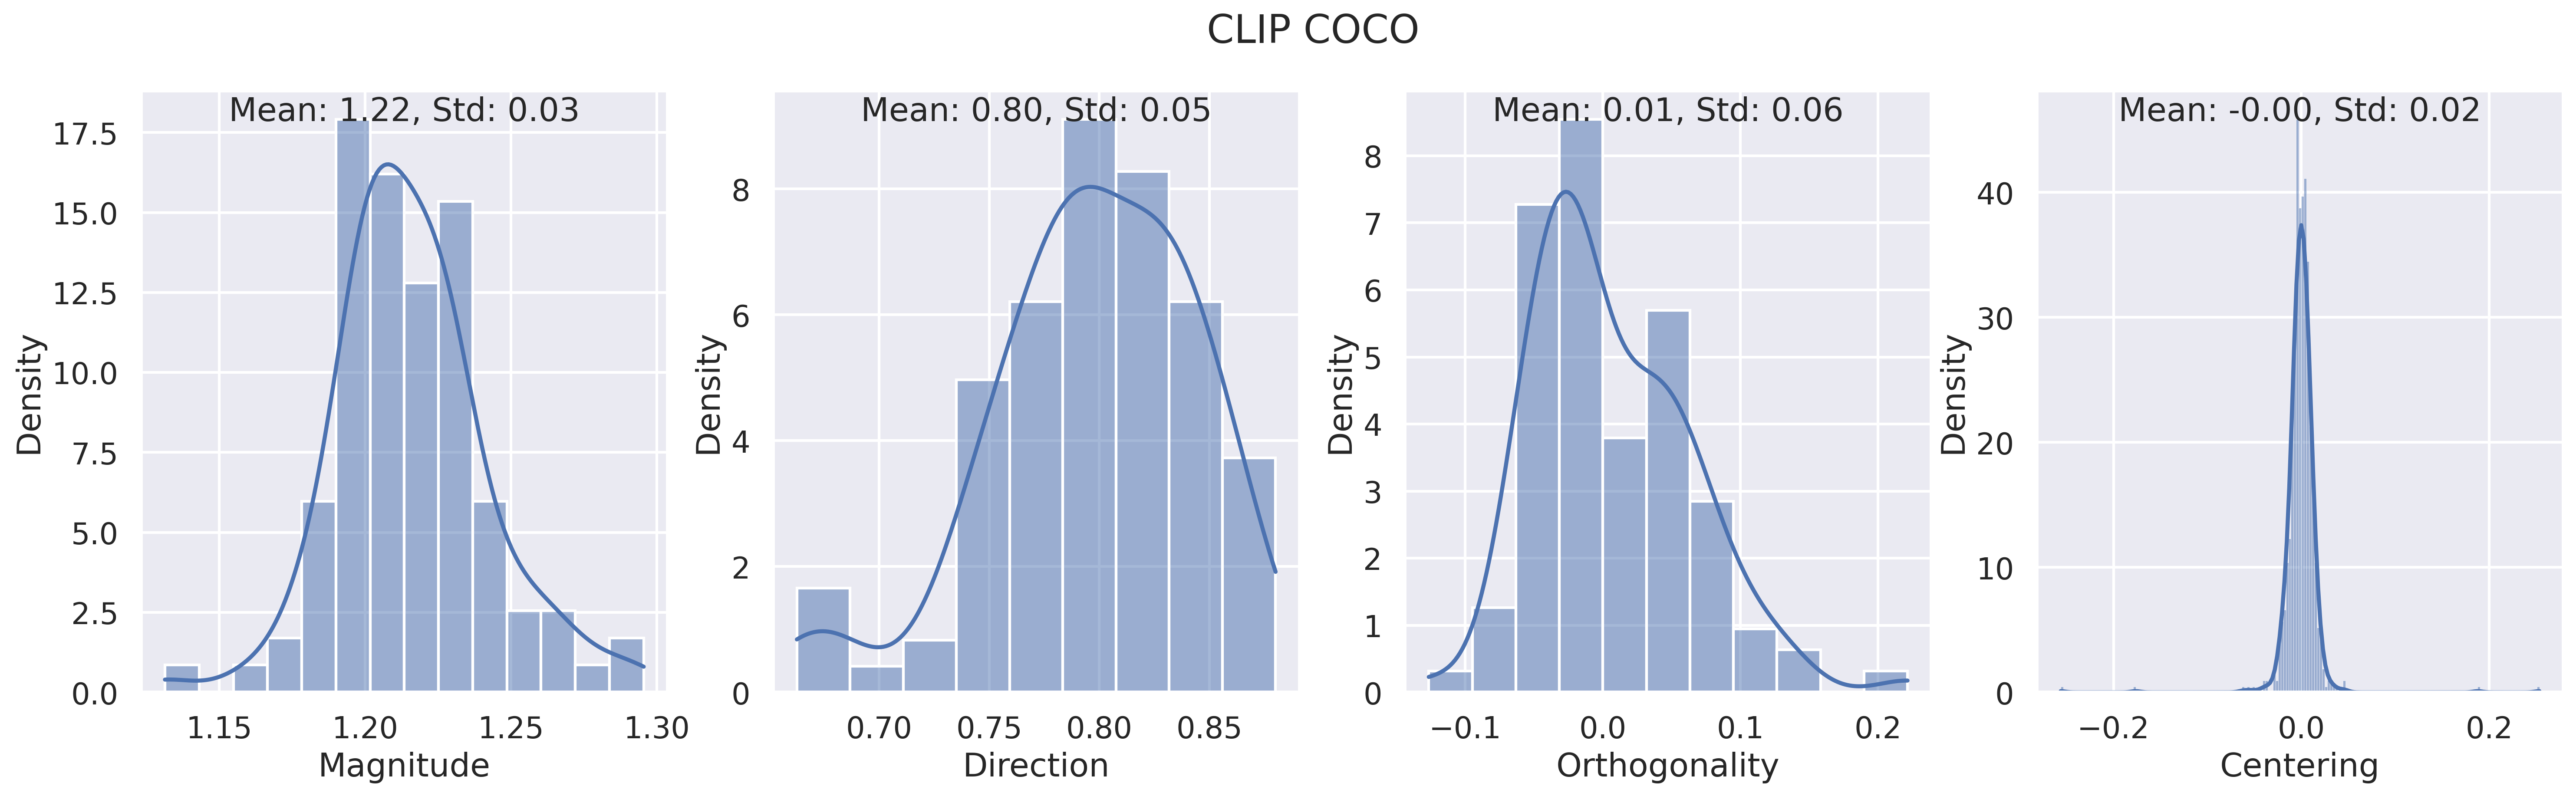

In [3]:
AVG_OUTPUT_EMBED_FOLDER = f"/pasteur/u/esui/data/dalle2/coco_prior_output_ViT-L_14_train_mini_avg_100x50"

features = torch.load(f"{AVG_OUTPUT_EMBED_FOLDER}/features.pt")
_ = compute_gap_statistics(
    features["image_features"], features["text_features"], None, None, None, "CLIP COCO"
)
# _ = compute_gap_statistics(
#     features["image_features"],
#     features["text_features"],
#     features["labels"],
#     features["labels"],
#     100,
#     "CLIP COCO Class",
# )